# Gabor Discrimination Analysis

In [1]:
import numpy as np
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import sem


### Exclusion Criteria

Pre-registered on OSF: https://osf.io/fuhpm
    

In [116]:
def combineCSVs(datafolder):
    """
    Combine all participant data into one pandas df
    OR 
    Create df for single participant file 
    """
    
    exclude = []
    
    #checks if path is a file
    isFile = os.path.isfile(datafolder)

    #checks if path is a directory
    
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
                if df.experimentName.unique()=='Gabor-Discrimination':
                    if df.versionName.unique()=='v2':
                        subjID = df.subjID.unique()[0]
                        if subjID not in exclude:
                            data.append(df)

                
        input_frame = pd.concat(data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            input_frame = pd.read_csv(datafolder, index_col=None, header=0)
    
    print('Number of participants before cleaning: ', len(input_frame.subjID.unique()))

 
    return input_frame

In [117]:

data_path = '/Users/prachimahableshwarkar/Documents/GW/FacialAge/FacialAge_MTurk/OSS_Exp2_MTurk/data'

In [118]:
input_data = combineCSVs(data_path)

Number of participants before cleaning:  264


In [119]:
num_trials = 12

In [120]:
def cleanbyPracticeTries(df, num_allowed_tries):
    all_subjIDs = df.subjID.unique()
    
    remove = []
    df2_list = []
    prac_too_many_dist = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        
        subj_num_practice_tries = cleaned_subj_df.pracTries.unique()[0]
        
        if subj_num_practice_tries > num_allowed_tries:
            prac_too_many_dist.append(subj_num_practice_tries)
            remove.append(subj)
        else:  
            df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
            
    print('Number of participants with more than ' + str(num_allowed_tries) + ' practice tries:', len(remove))
    
    return df2, prac_too_many_dist
    

In [121]:
pracTries_cleaned_data, prac_dist = cleanbyPracticeTries(input_data, 3)

Number of participants with more than 3 practice tries: 18


In [122]:
len(pracTries_cleaned_data.subjID.unique())

246

In [123]:
def Accuracy_Cleaning(df, accuracy_threshold, num_trials):
    """    
    Remove participants with overall accuracy below the accuracy threshold (e.g. 0.7)
    
    Returns:
        data of participants that passed the accuracy threshold 
        list of the number of correct trials each participant got
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    df2_list = []
    list_trials_correct = []
    # number of participants where exclusion is because all responses were 'none'
    c = 0
    
    for subj in all_subjIDs:
        keypresses = []

        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        
        subj_num_correct_trials = 0
        
        acc_column = np.array(list(subj_df['accuracy']))
        sum_acc = np.sum(acc_column)
        
        
        for idx, row in subj_df.iterrows():
            trial_acc = row['accuracy']
            if trial_acc == 1:
                subj_num_correct_trials += 1
            else:
                keypresses.append(row['keyPress'])
        
        subj_acc = sum_acc/num_trials
#         print(acc_column)
#         print(subj, sum_acc, subj_acc)
                
        # minimum number of trials correct the participant must have to be included
        if subj_acc < accuracy_threshold:
#             print(subj_acc, subj)
            remove.append(subj)
#             print(len([x for x in keypresses if x == 'none']))
            if len([x for x in keypresses if x == 'none']) >= 4:
                c += 1
            
#         else:
#             print(subj_acc)
        
        list_trials_correct.append(subj_num_correct_trials)
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    
    print("Number of Participants with accuracy below 70%: ", len(remove))
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
                
    print('Number of participants that did not respond for 4 or more trials:', c)
    
    print('Number of participants left: ', len(df2.subjID.unique()))
                
    return df2, list_trials_correct, keypresses

In [124]:
Accuracy_cleaned_data, correct_trials_distribution, keypresses = Accuracy_Cleaning(pracTries_cleaned_data, 0.7, num_trials)


Number of Participants with accuracy below 70%:  35
Number of participants that did not respond for 4 or more trials: 0
Number of participants left:  211


In [125]:
def RT_Cleaning(df, outlier_range, num_trials):
    """
    Remove trials where trial RT is outside of the defined outlier range 
    
    Returns:
        dataframe with outlier RT trials removed
        list of all RTs 
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    print(len(all_subjIDs))
    
    remove = []
    df2_list = []
    total_RT_outliers = 0
    total = 0
    list_trialRT = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 

        for idx, row in subj_df.iterrows():
            total += 1
            RT = row["RT"]
            list_trialRT.append(RT)
            if RT < outlier_range[0]: # outlier
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                total_RT_outliers += 1
            if RT > outlier_range[1]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                total_RT_outliers += 1
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    print(len(df2.subjID.unique()))
                
    return df2, list_trialRT

In [126]:
RT_cleaned_data, trialRTs_distribution = RT_Cleaning(Accuracy_cleaned_data, [250, 5000], num_trials)


211
210


In [131]:
def finalTrialCountCheck(df, num_trials, min_trials):
    """
    If more then 10% of a participants data is missing, remove the participant
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        count_trials = len(subj_df.index)
        if count_trials < min_trials:
            remove.append(subj)
            
#         threshold_trials_remaining = num_trials - math.floor(num_trials * 0.1)

#         if count_trials <= threshold_trials_remaining:
#             remove.append(subj)
            
    print("Number of Participants with >= 10% trials removed: ", len(remove))
            
    for subj in remove:
        df.drop(df[df['subjID'] == subj].index, inplace = True) 
                    
    print("Number of participants left: ",len(df.subjID.unique()))
    return df

In [132]:
finalTrialCount_data = finalTrialCountCheck(RT_cleaned_data, num_trials, 11)

Number of Participants with >= 10% trials removed:  18
Number of participants left:  192


In [133]:
raw_final_data = finalTrialCount_data.copy(deep=True)
len(raw_final_data.subjID.unique())

192

In [136]:
def zscored_outcomes(df):
    '''
    z-score depth estimates and RTs:
        for each subj calculate their avg and std 
        zscored = (estim - subj avg)/subj std
    '''
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    df2_list = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        final_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        # Z-Score RT
        average_RT = subj_df["RT"].mean()
        std_RT = subj_df["RT"].std()
        subj_RTs = np.array(list(subj_df["RT"]))
        zscored_subj_RTs = (subj_RTs - average_RT)/std_RT
        final_subj_df.insert(4, 'Z-Scored RT',zscored_subj_RTs)
        df2_list.append(final_subj_df)
    
    df2 = pd.concat(df2_list)    

    return df2

In [137]:
zs_final_data = zscored_outcomes(raw_final_data)

In [138]:
final_data = zs_final_data.copy(deep=True)

In [139]:
def add_image_col(df):
    """
    """
    image_col = []
    
    for idx, row in df.iterrows():
        image_col.append(row['image'][:-6])

    
    return np.array(image_col)

In [140]:
image_column = add_image_col(final_data)

# # add misscaled column to dataframe 
final_data.insert(14, "image_name", image_column)


In [141]:
def add_size_col(df):
    """
    """
    big_objects = ['clipboard', 'kettle', 'laptop', 'notebook', 'pot', 'toaster']
    small_objects = ['binderclip', 'eraser', 'flashdrive', 'saltshaker', 'sponge', 'spoon']
    
    size_col = []
    
    for idx, row in df.iterrows():
        obj = row['object']
        presentationSize = row['presentationSize']
        if obj in big_objects:
            if presentationSize == 'large':
                size_col.append('canonical')
            if presentationSize =='small':
                size_col.append('tooSmall')
        if obj in small_objects:
            if presentationSize == 'large':
                size_col.append('tooBig')
            if presentationSize =='small':
                size_col.append('canonical')
                
        size_col.append(row['image'][:-6])

    
    return np.array(size_col)

In [142]:
size_column = add_size_col(final_data)

# # add misscaled column to dataframe 
final_data.insert(14, "size_name", image_column)


In [143]:
final_data = final_data.copy(deep=True)

In [145]:
len(final_data.subjID.unique())

192

In [28]:
def add_cannonicalSize_col(df):
    """
    """
    big_objects = ['clipboard', 'kettle', 'laptop', 'notebook', 'pot', 'toaster']
    small_objects = ['binderclip', 'eraser', 'flashdrive', 'saltshaker', 'sponge', 'spoon']
    
    cannonicalSize_col = []
    
    for idx, row in df.iterrows():
        obj = row['object']
        if obj in big_objects:
            cannonicalSize_col.append('large')
        if obj in small_objects:
            cannonicalSize_col.append('small') 
    
    return np.array(cannonicalSize_col)

In [31]:
cannonicalSize_column = add_cannonicalSize_col(final_data)


In [32]:

# add cannonical size column to dataframe 
final_data.insert(14, "cannonical_size", cannonicalSize_column)

In [33]:
final_data.to_csv('gabor-discrim-data.csv', index=False)

### Read in data if outlier exclusion pipeline has already been run through

In [2]:
final_data = pd.read_csv('gabor-discrim-data.csv')

## Accuracy

#### Factors of interest: scale, objSceneSemCong

Presentation size is always large in this design

In [4]:
def get_proportion_correct(df):
    '''
    get proportion correct, and standard error 
    '''
    length = len(np.array(df['accuracy']))

    pc = np.sum(np.array(df['accuracy']))/length
    sem = np.std(np.array(df['accuracy']))/np.sqrt(length)

    return pc, sem, np.array(df['accuracy'])


In [5]:
overall_acc, overall_sem, all_acc_responses = get_proportion_correct(final_data)
overall_acc, overall_sem

(0.9558566433566433, 0.004294385702404959)

### Test for main effect of scale

In [6]:
scaled_acc, scaled_sem, scaled_acc_responses = get_proportion_correct(final_data.loc[final_data['scale']=='scaled'])
misscaled_acc, misscaled_sem, misscaled_acc_responses = get_proportion_correct(final_data.loc[final_data['scale']=='misscaled'])

scaled_acc, misscaled_acc

(0.9642545771578029, 0.9474145486415425)

In [5]:
from scipy.stats import ttest_rel
import random

def run_ttest(list0, list1):
    if len(list0) != len(list1):
        size = min(len(list0), len(list1))
        # print(size)
        # print(len(list0), len(list1))
        sampled_list0 = random.sample(list0, size)
        sampled_list1 = random.sample(list1, size)
    else:
        sampled_list0 = list0
        sampled_list1 = list1

    t_statistic, p_value = ttest_rel(sampled_list0, sampled_list1)

    return t_statistic, p_value


def main_ttest(reps, list0, list1):
    t_vals = []
    p_vals = []
    for i in range(reps):
        tv, pv = run_ttest(list0, list1)
        t_vals.append(tv)
        p_vals.append(pv)

    return np.mean(np.array(t_vals)), np.mean(np.array(p_vals))

In [12]:
print('Scaled vs Misscaled')
main_ttest(10000, scaled_acc_responses.tolist(), misscaled_acc_responses.tolist())


Scaled vs Misscaled


(1.9592869819768646, 0.05070443234217701)

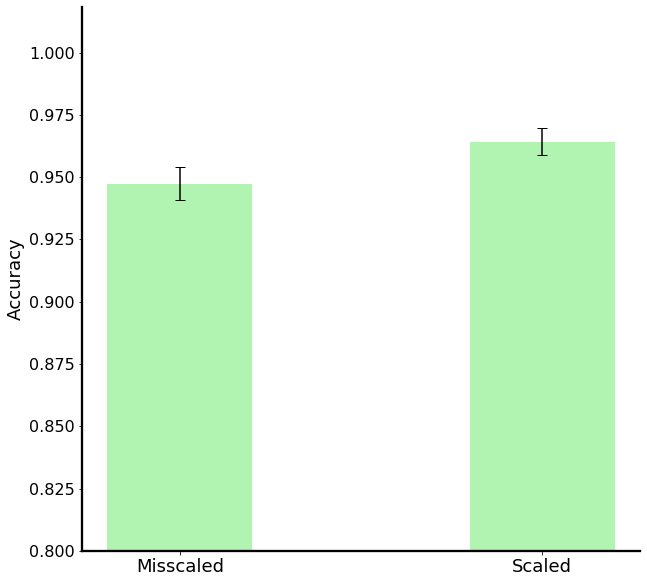

In [155]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
data_scale = {'Misscaled':misscaled_acc, 'Scaled':scaled_acc}

   
# creating the bar plot
plt.bar(list(data_scale.keys()), list(data_scale.values()), color ='lightgreen', alpha=0.7,
        width = 0.4, yerr=[misscaled_sem, scaled_sem], capsize=5)


plt.xticks(fontsize=18) 
plt.yticks(fontsize=16) 
plt.ylim(0.8)
plt.ylabel("Accuracy", fontsize=18)
plt.show()

### Test for main effect of object-scene semantic congruency

objSceneSemIncong = 0

objSceneSemCong = 1

In [156]:
cong_acc, cong_sem, cong_acc_responses = get_proportion_correct(final_data.loc[final_data['objSceneSemCong']== 1])
incong_acc, incong_sem, incong_acc_responses = get_proportion_correct(final_data.loc[final_data['objSceneSemCong']== 0])

cong_acc, incong_acc

(0.9554973821989529, 0.9562171628721541)

In [157]:
from scipy.stats import ttest_rel

print(len(cong_acc_responses), len(incong_acc_responses))

t_statistic, p_value = ttest_rel(cong_acc_responses[:-3], incong_acc_responses)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

1146 1142


ValueError: unequal length arrays

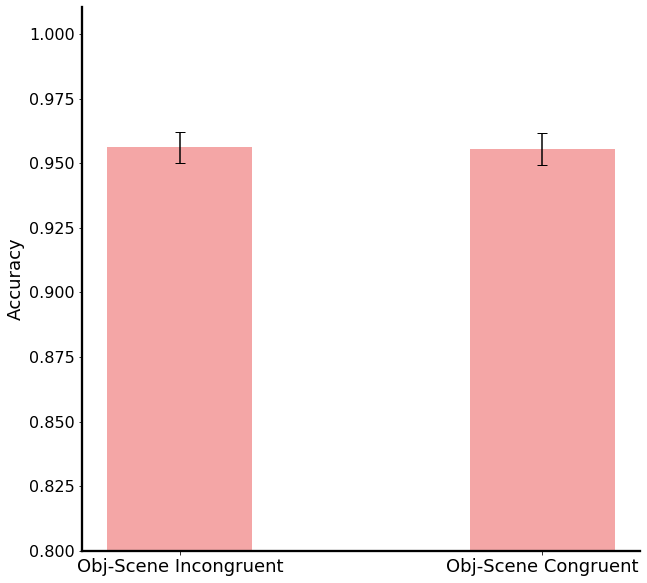

In [158]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
data_OSS = {'Obj-Scene Incongruent':incong_acc, 'Obj-Scene Congruent':cong_acc}

   
# creating the bar plot
plt.bar(list(data_OSS.keys()), list(data_OSS.values()), color ='lightcoral', alpha=0.7,
        width = 0.4, yerr=[incong_sem, cong_sem], capsize=5)


plt.xticks(fontsize=18) 
plt.yticks(fontsize=16) 
plt.ylim(0.8)
plt.ylabel("Accuracy", fontsize=18)
plt.show()

In [9]:
results_accuracy = {}
conditions = {'scale': ['scaled', 'misscaled'], 'objSceneSemCong': [1, 0]}

for scale in conditions['scale']:
    for objSceneSemCong in conditions['objSceneSemCong']:
        combination = f"{scale} + {objSceneSemCong}"
        combination_df = final_data[(final_data['objSceneSemCong'] == objSceneSemCong) & (final_data['scale'] == scale)]
        results_accuracy[combination] = get_proportion_correct(combination_df)
        
results_accuracy.keys()

dict_keys(['scaled + 1', 'scaled + 0', 'misscaled + 1', 'misscaled + 0'])

In [160]:
# print(len(results_accuracy['scaled + 1'][2]), len(results_accuracy['misscaled + 1'][2]))

# t_statistic, p_value = ttest_rel(results_accuracy['scaled + 1'][2][:-10], results_accuracy['misscaled + 1'][2])

# print("T-statistic:", t_statistic)
# print("P-value:", p_value)

In [3]:
fig_destination = '/Users/prachimahableshwarkar/Documents/GW/OSS/figures'

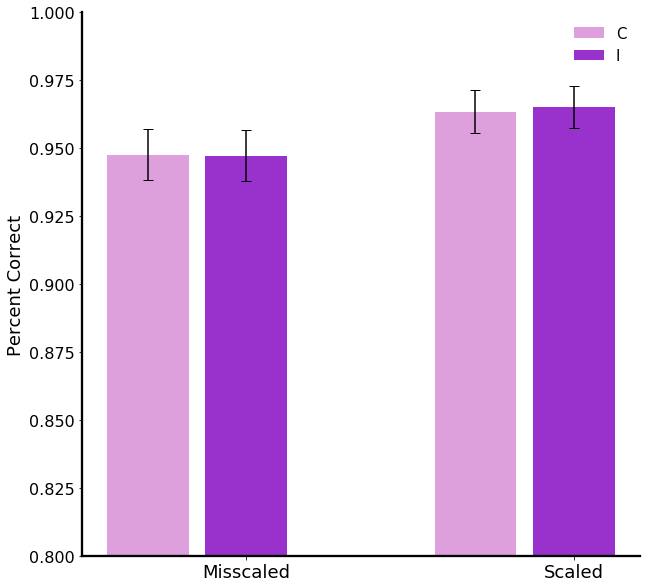

In [11]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(2)

#                                     Misscaled                             Scaled
Acc_objSemCong =   [results_accuracy['misscaled + 1'][0], results_accuracy['scaled + 1'][0]]
yerr_objSemCong =  [results_accuracy['misscaled + 1'][1], results_accuracy['scaled + 1'][1]]


Acc_objSemIncong =   [results_accuracy['misscaled + 0'][0], results_accuracy['scaled + 0'][0]]
yerr_objSemIncong =  [results_accuracy['misscaled + 0'][1], results_accuracy['scaled + 0'][1]]


width = 0.25
  
# plot data in grouped manner of bar type
plt.bar(x-0.3, Acc_objSemCong, width, color='plum', label='C', yerr=yerr_objSemCong, capsize=5)
plt.bar(x, Acc_objSemIncong, width, color='darkorchid', label='I', yerr=yerr_objSemIncong, capsize=5)


plt.xticks(x, ['Misscaled', 'Scaled'], fontsize='18')
plt.ylim(0.80, 1)
plt.yticks(fontsize=16) 
plt.ylabel("Percent Correct", fontsize=18)
plt.legend(loc=1, fontsize=15, frameon=False)

plt.savefig(fig_destination + '/exp2-acc-scale-x-OSS.png', dpi=300)  # Adjust the dpi value as needed for higher or lower resolution

plt.show()

## RT: Correct-trials only

In [6]:
final_data_CO = final_data.loc[final_data['accuracy']==1]

col = 'Z-Scored RT'



In [8]:
final_data_CO_renamed = final_data_CO.rename(columns={'Z-Scored RT': 'zsRT'})


final_data_CO_renamed.to_csv('gabor-discrim-CO_RT.csv', index=False)

In [9]:
def get_RT_descriptives(df, col):
    '''
    get avg RT, and standard error 
    '''

    avgRT = np.mean(np.array(df[col]))
    semRT = sem(np.array(df[col]))

    return avgRT, semRT, np.array(df[col])

### Scale

In [10]:
scaled_avgRT, scaled_RT_sem, scaled_RT_responses = get_RT_descriptives(final_data_CO.loc[final_data_CO['scale']=='scaled'], col)
misscaled_avgRT, misscaled_RT_sem, misscaled_RT_responses = get_RT_descriptives(final_data_CO.loc[final_data_CO['scale']=='misscaled'], col)

scaled_avgRT, misscaled_avgRT

(-0.15905606987067497, 0.13874834010440448)

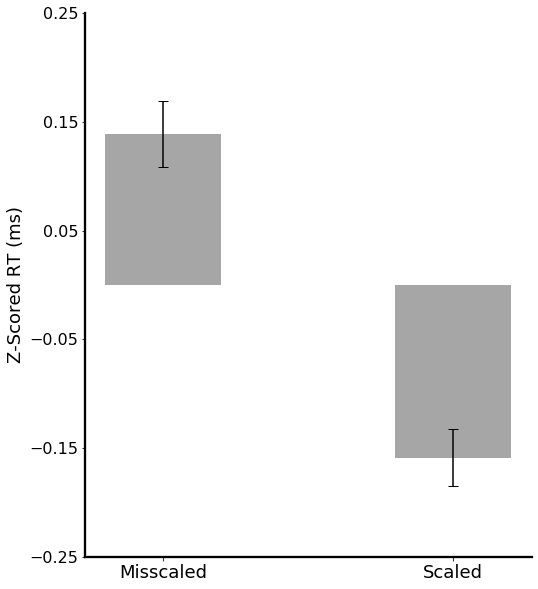

In [7]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
RT_data_scale = {'Misscaled':misscaled_avgRT, 'Scaled':scaled_avgRT}

   
# creating the bar plot
plt.bar(list(RT_data_scale.keys()), list(RT_data_scale.values()), color ='gray', alpha=0.7,
        width = 0.4, yerr=[misscaled_RT_sem, scaled_RT_sem], capsize=5)


plt.xticks(fontsize=18) 
plt.ylim(-0.25, 0.25)
plt.yticks(np.arange(-0.25, 0.3, 0.1),fontsize=16) 
plt.ylabel("Z-Scored RT (ms)", fontsize=18)

plt.savefig(fig_destination + '/exp2-RT-scale.png', dpi=300)  # Adjust the dpi value as needed for higher or lower resolution
plt.show()

### Effect of Scale by Objects

In [14]:
objects = final_data_CO.object.unique()

objects

array(['clipboard', 'flashdrive', 'sponge', 'spoon', 'toaster',
       'saltshaker', 'kettle', 'binderclip', 'eraser', 'laptop',
       'notebook', 'pot'], dtype=object)

In [15]:
def get_RT(df, col):

    return np.mean(np.array(df[col])), sem(np.array(df[col]))

In [16]:
# Misscaled
objects_avgRT = {}
objects_semRT = {}

for obj in objects:
    obj_df = final_data_CO.loc[final_data_CO['object']==obj]
    obj_RT_results = get_RT(obj_df, col)
    # add to appropriate dictionary
    objects_avgRT[obj] = obj_RT_results[0]
    objects_semRT[obj] = obj_RT_results[1]


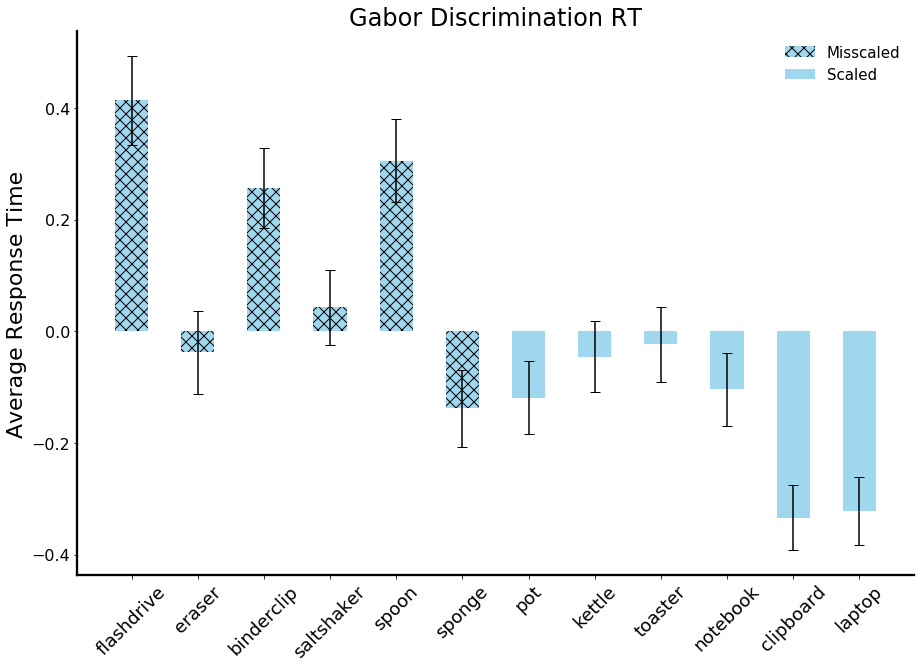

In [23]:
fig, ax = plt.subplots(figsize=[15,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

# Convert dictionaries to lists for plotting
objects_labels = ['flashdrive', 'eraser', 'binderclip', 'saltshaker', 'spoon', 'sponge', 'pot', 'kettle', 'toaster', 'notebook', 'clipboard', 'laptop', ]

avgRT = [objects_avgRT[obj] for obj in objects_labels]
semRT = [objects_semRT[obj] for obj in objects_labels]

# Determine the split index for the first half of the objects
split_index = len(objects) // 2

# X locations for the objects
ind = np.arange(len(objects_labels))
width = 0.5  # Width of the bars

# Plot the first half with 'xx' hatching
rects1 = ax.bar(ind[:split_index], avgRT[:split_index], width, yerr=semRT[:split_index],
                label='Misscaled', capsize=5, alpha=0.8, color='skyblue', hatch='xx')
# Plot the second half without hatching
rects2 = ax.bar(ind[split_index:], avgRT[split_index:], width, yerr=semRT[split_index:],
                label='Scaled', capsize=5, alpha=0.8, color='skyblue')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Average Response Time', fontsize=22)
ax.set_xticks(ind)
ax.set_xticklabels(objects_labels, rotation=45)

plt.xticks(fontsize=18)
plt.yticks(fontsize=16) 
plt.legend(loc=0, fontsize=15, frameon=False)
plt.title('Gabor Discrimination RT', fontsize=24)

plt.show()


### Obj-Scene Congruency

In [8]:
cong_avgRT, cong_RT_sem, cong_RT_responses = get_RT_descriptives(final_data_CO.loc[final_data_CO['objSceneSemCong']== 1], col)
incong_avgRT, incong_RT_sem, incong_RT_responses = get_RT_descriptives(final_data_CO.loc[final_data_CO['objSceneSemCong']== 0], col)

cong_avgRT, incong_avgRT

(0.033538443075490545, -0.05737513991920093)

In [170]:
print(len(cong_RT_responses), len(incong_RT_responses))


t_statistic, p_value = ttest_rel(cong_RT_responses[:-3], incong_RT_responses)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

1095 1092
T-statistic: 2.1368085907152596
P-value: 0.03283549247348835


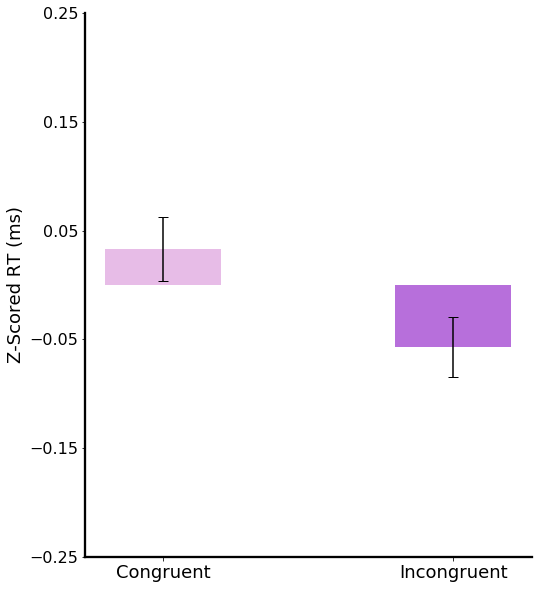

In [13]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
RT_data_OSS = {'Congruent':cong_avgRT, 'Incongruent':incong_avgRT, }


colors = ['plum', 'darkorchid']  # Specifying colors for each bar
# creating the bar plot
plt.bar(list(RT_data_OSS.keys()), list(RT_data_OSS.values()), color =colors, alpha=0.7,
        width = 0.4, yerr=[cong_RT_sem, incong_RT_sem], capsize=5)



plt.xticks(fontsize=18) 
plt.ylim(-0.25, 0.25)
plt.yticks(np.arange(-0.25, 0.3, 0.1),fontsize=16) 
plt.ylabel("Z-Scored RT (ms)", fontsize=18)

plt.savefig(fig_destination + '/exp2-RT-OSS.png', dpi=300)  # Adjust the dpi value as needed for higher or lower resolution
plt.show()

In [10]:
results_CO_RT = {}
conditions = {'scale': ['scaled', 'misscaled'], 'objSceneSemCong': [1, 0]}

for scale in conditions['scale']:
    for objSceneSemCong in conditions['objSceneSemCong']:
        combination = f"{scale} + {objSceneSemCong}"
        combination_df = final_data_CO[(final_data_CO['objSceneSemCong'] == objSceneSemCong) & (final_data_CO['scale'] == scale)]
        results_CO_RT[combination] = get_RT_descriptives(combination_df, col)
        
results_CO_RT.keys()

dict_keys(['scaled + 1', 'scaled + 0', 'misscaled + 1', 'misscaled + 0'])

In [185]:
print(len(results_accuracy['scaled + 1'][2]), len(results_accuracy['scaled + 0'][2]))

t_statistic, p_value = ttest_rel(results_accuracy['scaled + 1'][2][:-1], results_accuracy['scaled + 0'][2])

print("T-statistic:", t_statistic)
print("P-value:", p_value)

print(len(results_accuracy['misscaled + 1'][2]), len(results_accuracy['misscaled + 0'][2]))

t_statistic, p_value = ttest_rel(results_accuracy['misscaled + 1'][2][:-3], results_accuracy['misscaled + 0'][2])

print("T-statistic:", t_statistic)
print("P-value:", p_value)

print(len(results_accuracy['misscaled + 0'][2]), len(results_accuracy['scaled + 1'][2]))

t_statistic, p_value = ttest_rel(results_accuracy['misscaled + 0'][2], results_accuracy['scaled + 1'][2][:-5])

print("T-statistic:", t_statistic)
print("P-value:", p_value)

print(len(results_accuracy['misscaled + 1'][2]), len(results_accuracy['scaled + 0'][2]))

t_statistic, p_value = ttest_rel(results_accuracy['misscaled + 1'][2], results_accuracy['scaled + 0'][2][:-1])

print("T-statistic:", t_statistic)
print("P-value:", p_value)

574 573
T-statistic: -0.15604074614018293
P-value: 0.8760559574202444
572 569
T-statistic: 0.13233883348268552
P-value: 0.8947631589506848
569 574
T-statistic: -1.2864540523380457
P-value: 0.1988087414181662
572 573
T-statistic: -1.4447468511669161
P-value: 0.1490775248025175


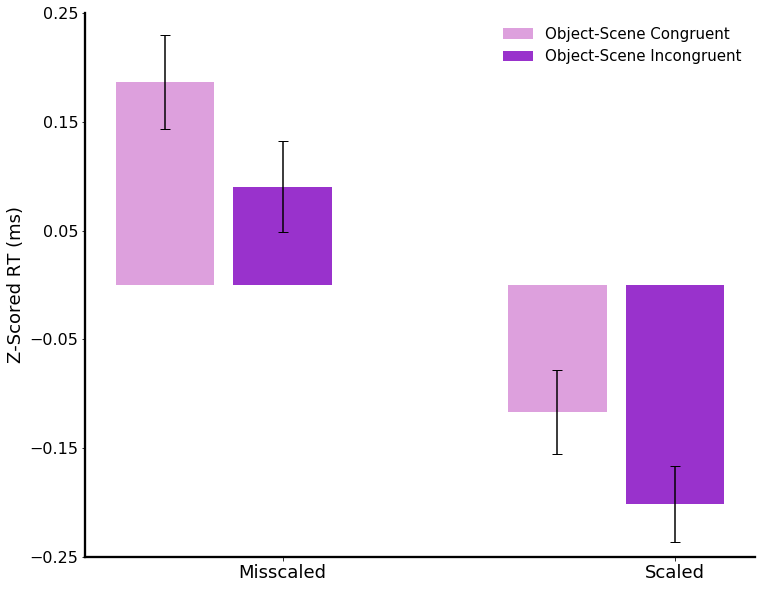

In [11]:
fig, ax = plt.subplots(figsize=[12,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(2)

#                                     Misscaled                             Scaled
RT_objSemCong =   [results_CO_RT['misscaled + 1'][0], results_CO_RT['scaled + 1'][0]]
yerr_objSemCong =  [results_CO_RT['misscaled + 1'][1], results_CO_RT['scaled + 1'][1]]


RT_objSemIncong =   [results_CO_RT['misscaled + 0'][0], results_CO_RT['scaled + 0'][0]]
yerr_objSemIncong =  [results_CO_RT['misscaled + 0'][1], results_CO_RT['scaled + 0'][1]]


width = 0.25
  
# plot data in grouped manner of bar type
plt.bar(x-0.3, RT_objSemCong, width, color='plum', label='Object-Scene Congruent', yerr=yerr_objSemCong, capsize=5)
plt.bar(x, RT_objSemIncong, width, color='darkorchid', label='Object-Scene Incongruent', yerr=yerr_objSemIncong, capsize=5)


plt.xticks(x, ['Misscaled', 'Scaled'], fontsize='18')
plt.ylim(-0.25, 0.25)
plt.yticks(np.arange(-0.25, 0.3, 0.1),fontsize=16) 

plt.ylabel("Z-Scored RT (ms)", fontsize=18)
plt.legend(loc=0, fontsize=15, frameon=False)

plt.savefig(fig_destination + '/exp2-RT-scale-OSS.png', dpi=300)  # Adjust the dpi value as needed for higher or lower resolution

plt.show()

## Inverse Efficiency Score

In [192]:
results_IES = {}
conditions = {'scale': ['scaled', 'misscaled'], 'objSceneSemCong': [1, 0]}

for scale in conditions['scale']:
    for objSceneSemCong in conditions['objSceneSemCong']:
        combination = f"{scale} + {objSceneSemCong}"
        combination_df = final_data[(final_data['objSceneSemCong'] == objSceneSemCong) & (final_data['scale'] == scale)]
        comb_RT, comb_RT_sem, comb_RT_responses = get_RT_descriptives(combination_df, col)
        comb_acc, comb_acc_sem, comb_acc_responses = get_proportion_correct(combination_df)

        results_IES[combination] = comb_RT/comb_acc
        
results_IES.keys()

dict_keys(['scaled + 1', 'scaled + 0', 'misscaled + 1', 'misscaled + 0'])

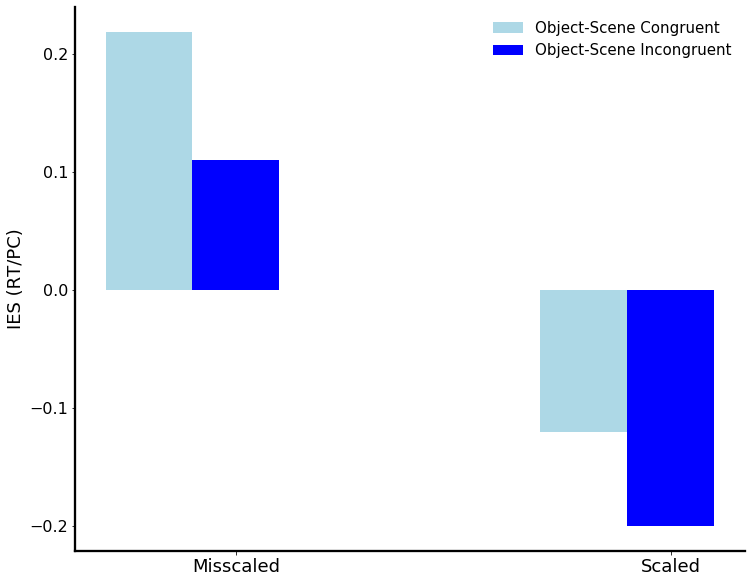

In [193]:
fig, ax = plt.subplots(figsize=[12,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(2)

#                                Misscaled                     Scaled
IES_objSemCong =   [results_IES['misscaled + 1'], results_IES['scaled + 1']]

IES_objSemIncong =   [results_IES['misscaled + 0'], results_IES['scaled + 0']]


width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, IES_objSemCong, width, color='lightblue', label='Object-Scene Congruent', capsize=5)
plt.bar(x, IES_objSemIncong, width, color='blue', label='Object-Scene Incongruent', capsize=5)


plt.xticks(x, ['Misscaled', 'Scaled'], fontsize='18')
plt.yticks(fontsize=16) 
# plt.ylim(1000)
plt.ylabel("IES (RT/PC)", fontsize=18)
plt.legend(loc=0, fontsize=15, frameon=False)

plt.show()

## Demographics + Other

### Screen Size

In [3]:
screenWidths = np.array(final_data['screenWidth'])
screenHeights = np.array(final_data['screenHeight'])

np.mean(screenWidths), np.std(screenWidths)

(1652.972027972028, 319.45375293853834)

### Time Taken

In [4]:
np.mean((np.array(final_data['totalTime'])//1000)/60), np.std((np.array(final_data['totalTime'])//1000)/60)

(6.550422494172494, 5.089886445013325)

### Age

In [5]:
ages = []
for subj in final_data.subjID.unique():
    subj_age = final_data.loc[final_data['subjID']==subj].age.unique()[0]
    if subj_age < 18:
        print(subj_age)
        pass
    else:
        if subj_age > 1900:
            print(subj_age)
            subj_age = 2023 - subj_age
            
    ages.append(subj_age)

np.mean(np.array(ages)), np.std(np.array(ages))

(28.203125, 8.7485350336142)

In [18]:
np.min(np.array(ages)), np.max(np.array(ages))

(18, 70)

### Gender

In [14]:
gender_dict_count = {}
for response in final_data.gender.unique():
    gender_dict_count[response] = 0

gender_dict_count

{'Man': 0,
 'Non-binary': 0,
 'Woman': 0,
 'Donna': 0,
 'Transgender': 0,
 'None of these describe me': 0,
 'Prefer not to answer': 0,
 'Kobieta': 0,
 'Hombre': 0}

In [15]:
translation_dict = {'Donna': 'Woman', 'Mujer': 'Woman', 'Mulher': 'Woman', 'Człowiek': 'Man', 'Kobieta': 'Woman', 'Hombre': 'Man', 'Homem': 'Man', 'WOMAN': 'Woman'}


In [16]:
gender_dict_count = {'Woman': 0,
                     'Man': 0,
                     'Transgender': 0,
                     'Transgender Woman': 0,
                     'Non-binary': 0,
                     'Genderqueer': 0,
                     'Prefer not to answer': 0,
                     'None of these describe me': 0}

for subj in final_data.subjID.unique():
    subj_gender = final_data.loc[final_data['subjID']==subj].gender.unique()[0]
    if subj_gender in translation_dict.keys():
        translated_gender = translation_dict[subj_gender]
        gender_dict_count[translated_gender] += 1
    else:
        gender_dict_count[subj_gender] += 1


In [17]:
gender_dict_count

{'Woman': 92,
 'Man': 89,
 'Transgender': 2,
 'Transgender Woman': 0,
 'Non-binary': 7,
 'Genderqueer': 0,
 'Prefer not to answer': 1,
 'None of these describe me': 1}